In [1]:
import torch
import torchvision
from  torchvision.transforms import ToTensor,Normalize,Compose 
from torchvision.datasets import MNIST

In [2]:
mnist=MNIST(root='.',
            train=True,
            download=True,
            transform=Compose([ToTensor(), Normalize(mean=(0.5,),std=(0.5,))]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
img,label=mnist[0]
print(img.shape,label)

torch.min(img),torch.max(img)

torch.Size([1, 28, 28]) 5


(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
  out=(x+1)/2
  return out.clamp(0,1)

Label 5


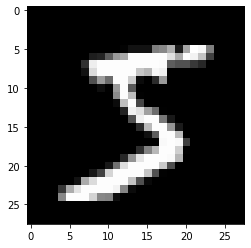

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
img_norm=denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label',label)

In [6]:
from torch.utils.data import DataLoader
batch_size=100

data_loader= DataLoader(mnist,batch_size,shuffle=True)

First batch
tensor([6, 1, 2, 4, 6, 5, 8, 1, 0, 0, 7, 2, 1, 0, 4, 8, 0, 7, 6, 1, 9, 1, 3, 2,
        1, 6, 8, 1, 1, 2, 1, 8, 3, 8, 6, 9, 8, 1, 8, 1, 4, 5, 4, 8, 8, 3, 6, 5,
        9, 9, 8, 1, 3, 0, 2, 8, 1, 2, 8, 4, 9, 3, 7, 0, 3, 1, 9, 8, 7, 0, 0, 9,
        1, 7, 1, 6, 2, 9, 7, 8, 4, 2, 8, 7, 1, 2, 4, 6, 4, 6, 7, 2, 7, 8, 5, 5,
        7, 9, 4, 0])


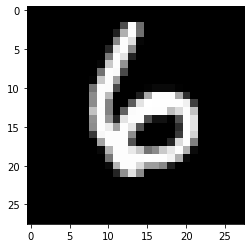

In [7]:
for img_batch,label_batch in data_loader:
  print('First batch')
  print(label_batch)
  plt.imshow(img_batch[0][0],cmap='gray')
  break

In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

# Discriminator


In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn


D=nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),

    nn.Linear(hidden_size,1),

    nn.Sigmoid()  

)

D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator

In [12]:
latent_size=64

In [13]:
G=nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()


    

)

In [14]:
y=G(torch.randn(2,latent_size))

In [15]:
y.shape

torch.Size([2, 784])

In [16]:
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())


In [17]:
device ,

(device(type='cuda'),)

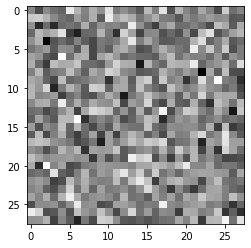

In [18]:
plt.imshow(gen_imgs[0], cmap='gray');


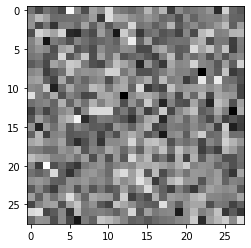

In [19]:
plt.imshow(gen_imgs[1], cmap='gray');


In [20]:
G.to(device);


# Discriminator Training


In [21]:
criterion=nn.BCELoss()
d_optimizer=torch.optim.Adam(D.parameters(),lr=0.0002)

In [22]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [23]:
def train_discriminator(images):

  real_labels=torch.ones(batch_size,1).to(device)
  fake_labels=torch.zeros(batch_size,1).to(device)

  #loss for real images
  outputs=D(images)
  d_real_loss=criterion(outputs,real_labels)
  real_score=outputs

    #loss for fake images

  z=torch.randn(batch_size,latent_size).to(device)
  fake_images=G(z)
  outputs=D(fake_images)

  d_fake_loss=criterion(outputs,fake_labels)
  fake_score=outputs

  #loss
  d_loss=d_real_loss+d_fake_loss


  #reset_grad
  reset_grad()

  d_loss.backward()

  d_optimizer.step()

  return d_loss, real_score, fake_score





In [24]:
# def train_discriminator(images):
#     # Create the labels which are later used as input for the BCE loss
#     real_labels = torch.ones(batch_size, 1).to(device)
#     fake_labels = torch.zeros(batch_size, 1).to(device)
        
#     # Loss for real images
#     outputs = D(images)
#     d_loss_real = criterion(outputs, real_labels)
#     real_score = outputs

#     # Loss for fake images
#     z = torch.randn(batch_size, latent_size).to(device)
#     fake_images = G(z)
#     outputs = D(fake_images)
#     d_loss_fake = criterion(outputs, fake_labels)
#     fake_score = outputs

#     # Combine losses
#     d_loss = d_loss_real + d_loss_fake
#     # Reset gradients
#     reset_grad()
#     # Compute gradients
#     d_loss.backward()
#     # Adjust the parameters using backprop
#     d_optimizer.step()
    
#     return d_loss, real_score, fake_score

# Generator training

In [25]:
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [26]:
def train_generator():

  z=torch.randn(batch_size,latent_size).to(device)
  fake_images=G(z)

  labels=torch.ones(batch_size,1).to(device)

  g_loss=criterion(D(fake_images),labels)


  reset_grad()

  g_loss.backward()

  g_optimizer.step()
  


  return g_loss,fake_images

In [27]:
# def train_generator():
#     # Generate fake images and calculate loss
#     z = torch.randn(batch_size, latent_size).to(device)
#     fake_images = G(z)
#     labels = torch.ones(batch_size, 1).to(device)
#     g_loss = criterion(D(fake_images), labels)

#     # Backprop and optimize
#     reset_grad()
#     g_loss.backward()
#     g_optimizer.step()
#     return g_loss, fake_images

# training models

In [28]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

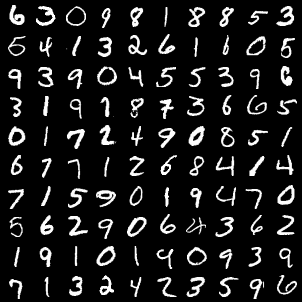

In [29]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

In [30]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images=G(sample_vectors)
  fake_images=fake_images.reshape(fake_images.size(0),1,28,28)
  fake_fname='fake_image-{0:0=4d}.png'.format(index)
  print('Saving',fake_fname)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=10)


#beofre_trainin
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


Saving fake_image-0000.png


In [31]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0408, g_loss: 4.4454, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1140, g_loss: 5.1973, D(x): 0.97, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0309, g_loss: 5.0118, D(x): 0.99, D(G(z)): 0.02
Saving fake_image-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1366, g_loss: 4.1704, D(x): 0.94, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 0.1253, g_loss: 3.8489, D(x): 0.96, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.9694, g_loss: 3.5641, D(x): 0.72, D(G(z)): 0.24
Saving fake_image-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.7095, g_loss: 3.7775, D(x): 0.86, D(G(z)): 0.26
Epoch [2/300], Step [400/600], d_loss: 0.1869, g_loss: 3.1340, D(x): 0.93, D(G(z)): 0.10
Epoch [2/300], Step [600/600], d_loss: 0.6285, g_loss: 2.5031, D(x): 0.72, D(G(z)): 0.13
Saving fake_image-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.6830, g_loss: 2.3839, D(x): 0.84, D(G(z)): 0.27
Epoch [3/300], Step [400/600]

In [32]:
# !zip -r ./samples.zip ./samples


  adding: samples/ (stored 0%)
  adding: samples/fake_image-0104.png (deflated 4%)
  adding: samples/fake_image-0210.png (deflated 4%)
  adding: samples/fake_image-0194.png (deflated 4%)
  adding: samples/fake_image-0269.png (deflated 4%)
  adding: samples/fake_image-0254.png (deflated 4%)
  adding: samples/fake_image-0180.png (deflated 4%)
  adding: samples/fake_image-0033.png (deflated 4%)
  adding: samples/fake_image-0293.png (deflated 4%)
  adding: samples/fake_image-0203.png (deflated 4%)
  adding: samples/fake_image-0034.png (deflated 5%)
  adding: samples/fake_image-0017.png (deflated 4%)
  adding: samples/fake_image-0292.png (deflated 4%)
  adding: samples/fake_image-0175.png (deflated 4%)
  adding: samples/fake_image-0090.png (deflated 4%)
  adding: samples/fake_image-0276.png (deflated 4%)
  adding: samples/fake_image-0157.png (deflated 4%)
  adding: samples/fake_image-0216.png (deflated 4%)
  adding: samples/fake_image-0052.png (deflated 4%)
  adding: samples/fake_image-0232

In [33]:
# from google.colab import files
# files.download("./samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>